# Mosquito collection sites

In this notebook we'll take a virtual tour of the locations where mosquitoes contributed to Ag1000G phase 3 were collected. We'll plot some maps to see the collection sites in their geographical context. For added interest, we'll also plot some other geographical data on the maps, such as [ecosystem classifications](http://www.aag.org/cs/publications/special/map_african_ecosystems) and ITN coverage from the [Malaria Atlas Project](https://malariaatlas.org/explorer/#/). 

As always, this notebook is executable, which means you can run it for yourself by clicking the launch icon (<i class="fas fa-rocket"></i>) at the top of the page and selecting one of the cloud computing services available. 

## Setup

To load geographical data and plot maps, we'll need to install some packages, including [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [rasterio](https://rasterio.readthedocs.io/en/latest/). Installing these packages can be a bit fiddly. If you're running this on Google Colab (or other Debian/Ubuntu systems and using pip to install Python packages) run the following code cell.

In [ ]:
# https://github.com/googlecolab/colabtools/issues/85#issuecomment-709241391
!apt-get -q install libgdal-dev libproj-dev libgeos-dev proj-data proj-bin
!pip install -q cython numpy scipy pyshp matplotlib pandas malariagen_data
!pip uninstall -q -y shapely  # make sure we have a fresh install
!pip install -q shapely --no-binary shapely
!pip install -q --upgrade cartopy
!pip install -q --upgrade rasterio

In [3]:
# check we have cartopy 0.18.0 or greater, needed to get tiles from google maps
import cartopy
cartopy.__version__

'0.19.0.post1'

Setup access to MalariaGEN data via Google Cloud.

In [4]:
import malariagen_data
ag3 = malariagen_data.Ag3()

To plot the extra geographical data, we'll need to download some files. 

The ecosystem classifications in full resolution are available from the [USGS website](http://rmgsc.cr.usgs.gov/outgoing/ecosystems/AfricaData/), but these are large files and higher resolution than we need. For convenience we've precomputed a downsampled version of these data, let's download it.  

In [ ]:
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG_5pc.tif
!wget --no-clobber https://storage.googleapis.com/vo_agam_release/reference/af_labeled_ecosys/Africa_IVC_20130316_final_MG.tif.vat.csv

Data from the Malaria Atlas Project can be downloaded from their [data explorer site](https://malariaatlas.org/explorer/). Let's download the most recent ITN coverage model.

In [ ]:
!wget --no-clobber -O 2020_Africa_ITN_Use.zip "https://malariaatlas.org/geoserver/Explorer/ows?service=CSW&version=2.0.1&request=DirectDownload&ResourceId=Explorer:2020_Africa_ITN_Use"
!unzip -n -d 2020_Africa_ITN_Use 2020_Africa_ITN_Use.zip

Let's also get data for country boundaries and physical features.

In [ ]:
!wget --no-clobber https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical --no-warn
!python cartopy_feature_download.py cultural --no-warn

Now let's define some functions for loading the map data and plotting a map, with support for different background options.

In [24]:
from functools import lru_cache
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM, GoogleTiles
import warnings
warnings.filterwarnings('ignore')

In [9]:
# setup some geographical projections
crs_lonlat = ccrs.PlateCarree()
crs_mercator = ccrs.Mercator()

In [10]:
@lru_cache(maxsize=None)
def load_ecosystems():
    """Load the African ecosystems data."""

    # build a matplotlib colour map from the colour table
    df_colors = pd.read_csv('Africa_IVC_20130316_final_MG.tif.vat.csv').set_index('Value')
    colors = np.zeros((df_colors.index.max() + 1, 3), dtype=float)
    for v, (r, g, b) in df_colors[['Red', 'Green', 'Blue']].iterrows():
        colors[int(v)] = r, g, b
    # fix the zero colour to be white
    colors[0] = 1, 1, 1
    cmap = mpl.colors.ListedColormap(colors)

    # load the image data
    image = rasterio.open("Africa_IVC_20130316_final_MG_5pc.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data < 0, image_data)  

    # determine image extent 
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )         

    return image_data, cmap, extent, crs_lonlat


In [11]:
@lru_cache(maxsize=None)
def load_itn_coverage(year):
    """Load ITN coverage data for a given year."""
    
    image = rasterio.open(f"2020_Africa_ITN_Use/2020_GBD2021_Africa_ITN_Coverage_{year}.tif")
    image_data = image.read(1)
    image_data = np.ma.masked_where(image_data <= 0, image_data)
    cmap = "RdYlGn"
    extent = (
        image.bounds.left, 
        image.bounds.right,
        image.bounds.bottom,
        image.bounds.top
    )
    return image_data, cmap, extent, crs_lonlat


In [16]:
def plot_sites(extent=None, sample_sets="3.0", sample_query=None, background='osm', 
               bgzoom=3, bgstyle='street', bgyear=2019, ax=None, figsize=(7, 7), gridlines=15,
               plot_kws=None, label_sites=False, title=None):
    """Plot a map of mosquito collection sites."""

    # normalise background parameter to lower case
    background = background.lower()

    if extent is None:
        # default to the whole of Africa
        extent = -26, 64, -35, 38

    # decide what projection to use
    if background in {'osm', 'google'}:
        # these backgrounds use Mercator projection and look best in their
        # native projection
        projection = ccrs.GOOGLE_MERCATOR
    else:
        # other backgrounds use Plate Carree, for simplicity use their
        # native projection
        projection = crs_lonlat
        
    # create a figure and axes to plot on
    if ax is None:
        fig = plt.figure(figsize=figsize, facecolor='w')
        ax = fig.add_subplot(111, projection=projection)

    # set the extent of the map
    ax.set_extent(extent, crs=crs_lonlat)

    # plot the background image

    if background == 'osm':
        # use OpenStreetMap as background
        imagery = OSM()
        ax.add_image(imagery, bgzoom)

    elif background == 'google':
        # use Google Maps as background
        imagery = GoogleTiles(style=bgstyle)
        ax.add_image(imagery, bgzoom)

    elif background == 'ecosystems':
        # use African Ecosystems as background
        image_data, image_cmap, image_extent, image_crs = load_ecosystems()
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)
        if title is None:
            title = 'Ecosystems'
        
    elif background == 'itn_coverage':
        # use ITN coverage as background
        image_data, image_cmap, image_extent, image_crs = load_itn_coverage(bgyear)
        ax.imshow(image_data, cmap=image_cmap, 
                  interpolation='nearest', extent=image_extent,
                  origin='upper', transform=image_crs)
        if title is None:
            title = f'ITN coverage ({bgyear})'

    if background in {"ecosystems", "itn_coverage"}:
        # add useful features
        ax.coastlines(resolution='50m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=1)
        
    if background == 'itn_coverage':
        ax.add_feature(cfeature.LAKES, linewidth=1)

    # draw gridlines
    if gridlines:
        gl = ax.gridlines(crs=crs_lonlat, 
                          xlocs=np.arange(-180, 180, gridlines), 
                          ylocs=np.arange(-180, 180, gridlines), 
                          draw_labels=True)
        gl.top_labels = None
        gl.right_labels = None
        
    if title is not None:
        ax.set_title(title)

    # plot sampling sites
    df_summary = None
    if sample_sets is not None:
        df_samples = ag3.sample_metadata(sample_sets=sample_sets)
        if sample_query is not None:
            df_samples = df_samples.query(sample_query)
        df_sites = df_samples[['location', 'longitude', 'latitude']].drop_duplicates()
        l = df_sites['location']
        x = df_sites['longitude']
        y = df_sites['latitude']
        if plot_kws is None:
            plot_kws = dict()
        plot_kws.setdefault('marker', 'o')
        plot_kws.setdefault('linestyle', ' ')
        plot_kws.setdefault('markeredgecolor', 'black')
        plot_kws.setdefault('markerfacecolor', 'red')
        plot_kws.setdefault('markersize', 6)
        plot_kws.setdefault('markeredgewidth', 1)
        if label_sites:
            # trick to allow us to use the annotate() method
            xycoords = crs_lonlat._as_mpl_transform(ax)
            for t, i, j in zip(l, x, y):
                t = ax.annotate(t, xy=(i, j), xycoords=xycoords, xytext=(0, 5), textcoords='offset points', 
                                ha='center', va='bottom', backgroundcolor=(1, 1, 1, .7))
        ax.plot(x, y, transform=crs_lonlat, zorder=10, **plot_kws)
        
        # build a summary dataframe showing numbers of samples
        df_summary = pd.DataFrame(df_samples.groupby(['sample_set', 'location', 'longitude', 'latitude', 'year', 'taxon']).size().rename('n_samples'))

    return df_summary

    

Let's try out the map plotting function, with the different backgound options.

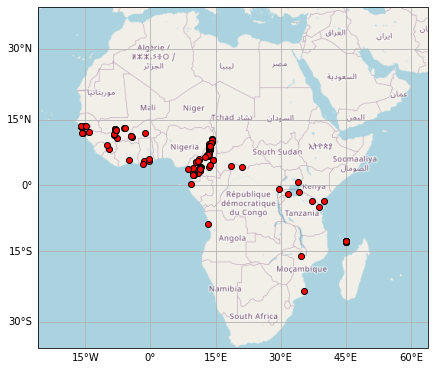

In [17]:
plot_sites(background='osm', bgzoom=3);

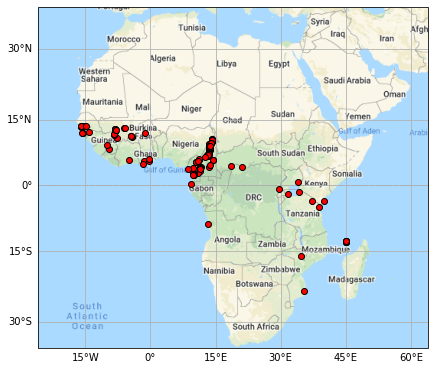

In [18]:
plot_sites(background='google', bgzoom=3, bgstyle='street');

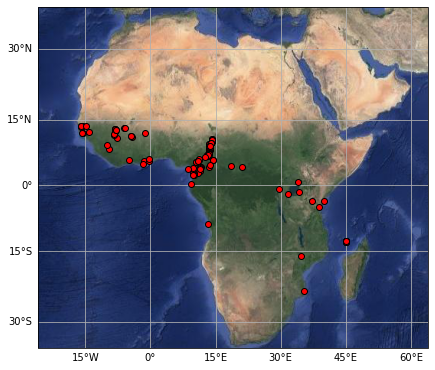

In [19]:
plot_sites(background='google', bgzoom=3, bgstyle='satellite');

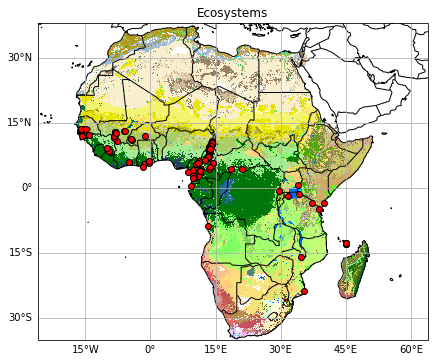

In [20]:
plot_sites(background='ecosystems');

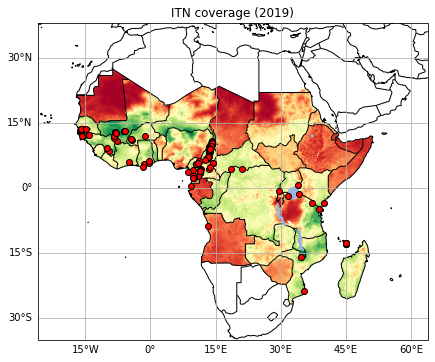

In [21]:
plot_sites(background='itn_coverage', bgyear=2019);

Let's add a function to make a multi-panel plot, so we can see some of these maps side-by-side.

In [22]:
def fig_sites(extent, sample_query, bgzoom=5, bgyear=2019, gridlines=None, 
              label_sites=True, figsize=(13, 6)):
    """Make a multi-panel figure of collection sites with different map backgrounds."""
    
    fig = plt.figure(figsize=figsize, facecolor='w')
    kwargs = dict(
        extent=extent,
        sample_query=sample_query,
        gridlines=gridlines,
        label_sites=label_sites,
    )
    ax = fig.add_subplot(1, 3, 1, projection=crs_mercator)
    plot_sites(background='google', bgzoom=bgzoom, ax=ax, **kwargs)
    ax = fig.add_subplot(1, 3, 2, projection=crs_lonlat)
    plot_sites(background='ecosystems', ax=ax, **kwargs)
    ax = fig.add_subplot(1, 3, 3, projection=crs_lonlat)
    df_summary = plot_sites(background='itn_coverage', bgyear=bgyear, ax=ax, **kwargs)
    return df_summary


Now let's zoom into some of the different collection sites, starting in East Africa and moving west. 

Please note that the plots below include ITN coverage estimated at the most recent date available (2019) but many of the samples included in Ag1000G phase 3 were collected well before that date, at a time when ITN coverage may have been very different. If you want to explore this, run this notebook changing the `bgyear` parameter.

## Mozambique

Mosquitoes were collected in the village of Furvela in 2003 and 2004 and are all *An. gambiae*. For more information about Furvela see [Charlwood et al. (2014)](https://pubmed.ncbi.nlm.nih.gov/25088021/) and references therein.

n_samples
sample_set location longitude latitude year taxon             
AG1000G-MZ Furvela  35.299    -23.716  2003 gambiae          3
                                       2004 gambiae         71

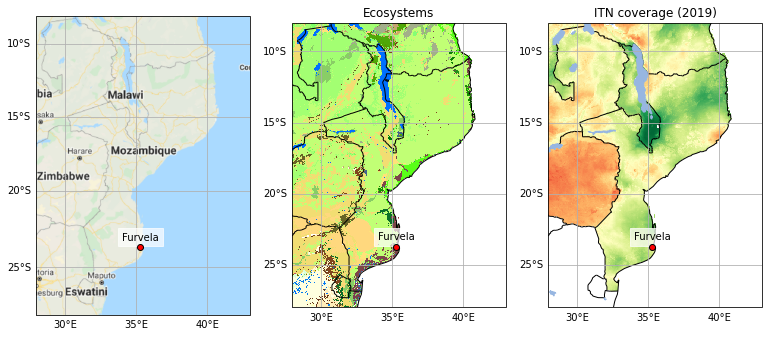

In [25]:
fig_sites(
    extent=(28, 43, -28, -8),
    sample_query='country == "Mozambique"',
    bgzoom=5,
    gridlines=5,
)

## Malawi

Mosquitoes were collected from several villages within the catchment of the Majete Malaria Project in Chikhwawa District in 2015, and are all *An. arabiensis*. More information about the collection site is available in [McCann et al. (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5610449/).

n_samples
sample_set location  longitude latitude year taxon                
AG1000G-MW Chikhwawa 34.755    -15.933  2015 arabiensis         41

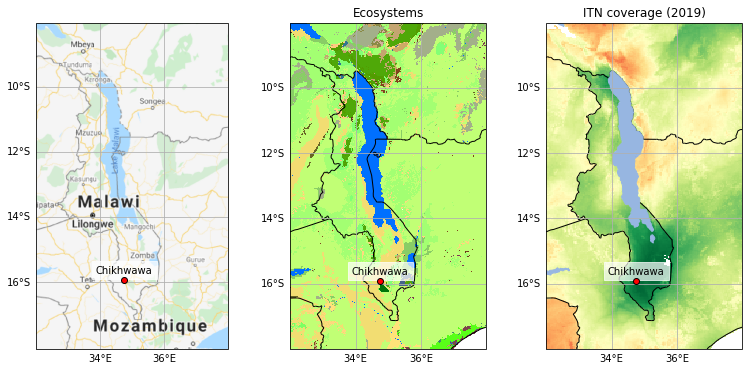

In [26]:
fig_sites(
    extent=(32, 38, -18, -8),
    sample_query='country == "Malawi"',
    bgzoom=6,
    gridlines=2,
)

## Tanzania

Mosquitoes were contributed from four different collection sites in north west and north east Tanzania. Most mosquitoes were *An. arabiensis* or *An. gambiae* but a subset of mosquitoes had an unexpected species genotype, being apparently intermediate between *An. gambiae* and *An. coluzzii*, which we're investigating further. For more information about these locations see [Kabula et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22519840/), [Matowo et al. (2014)](https://pubmed.ncbi.nlm.nih.gov/24946780/) and [Matiya et al. (2019)](https://malariajournal.biomedcentral.com/articles/10.1186/s12936-019-2738-6). 

n_samples
sample_set location longitude latitude year taxon                
AG1000G-TZ Moshi    37.308    -3.482   2012 arabiensis         40
           Muheza   38.948    -4.940   2013 arabiensis          1
                                            gambiae            32
                                            gcx3               10
           Muleba   31.651    -1.962   2015 arabiensis        137
                                            gambiae            32
                                            gcx3                1
           Tarime   34.199    -1.431   2012 arabiensis         47

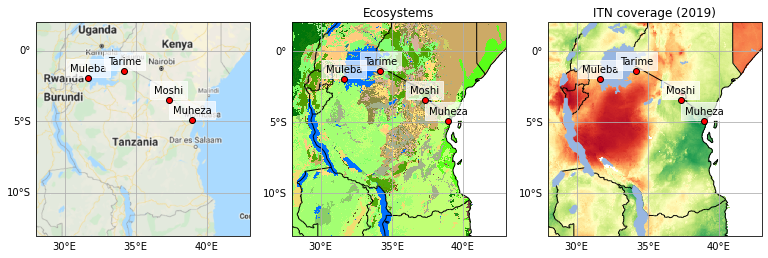

In [27]:
fig_sites(
    extent=(28, 43, -13, 2),
    sample_query='country == "Tanzania"',
    bgzoom=5,
    gridlines=5,
)

## Kenya

The Kenyan mosquitoes were collected from villages in Kilifi County. Similar to eastern Tanzania, there are *An. gambiae* and *An. arabiensis* in addition to mosquitoes with apparent intermediate species genotypes. Some more information about malaria entomology in Kilifi is available in [Midega et al. (2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3292715/).

n_samples
sample_set location longitude latitude year taxon                
AG1000G-KE Kilifi   39.909    -3.511   2000 gambiae            19
                                       2007 arabiensis          3
                                       2012 arabiensis         10
                                            gcx3               54

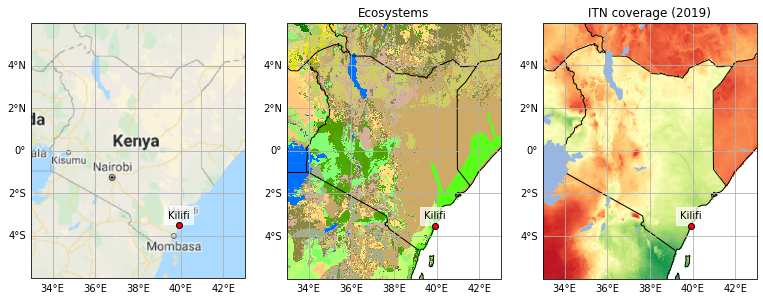

In [28]:
fig_sites(
    extent=(33, 43, -6, 6),
    sample_query='country == "Kenya"',
    bgzoom=5,
    gridlines=2,
)

## Uganda

Mosquitoes were collected from two sites in Uganda, with both *An. arabiensis* and *An. gambiae* collected in Nagongera in the east but almost exclusively *An. gambiae* from Kihihi in the west. More information about these collections is available in [Kilama et al. (2014)](https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-13-111).

n_samples
sample_set location  longitude latitude year taxon                                     
AG1000G-UG Kihihi    29.701    -0.751   2012 arabiensis                               1
                                             gambiae                                 95
           Nagongera 34.026     0.770   2012 arabiensis                              81
                                             gambiae                                112
                                             intermediate_arabiensis_gambiae          1

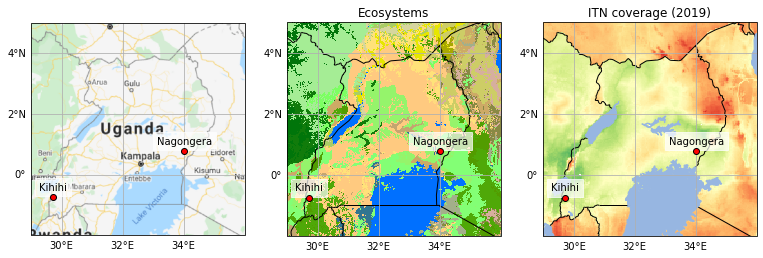

In [29]:
fig_sites(
    extent=(29, 36, -2, 5),
    sample_query='country == "Uganda"',
    bgzoom=6,
    gridlines=2,
)

## Democratic Republic of the Congo

*An. gambiae* mosquitoes were collected from the town of Gbadolite in the far north, close to the border with the Central African Republic. 

n_samples
sample_set location  longitude latitude year taxon             
AG1000G-CD Gbadolite 21.017    4.283    2015 gambiae         76

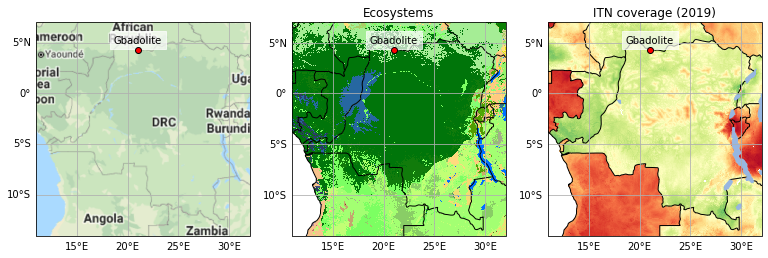

In [55]:
fig_sites(
    extent=(11, 32, -14, 7),
    sample_query='country == "Democratic Republic of the Congo"',
    bgzoom=4,
    gridlines=5,
)

## Central African Republic

Mosquitoes were collected in the capital Bangui. Both *An. gambiae* and *An. coluzzii* are represented. These are the oldest mosquitoes in Ag1000G, collected in 1993 and 1994.

n_samples
sample_set location longitude latitude year taxon              
AG1000G-CF Bangui   18.583    4.367    1993 coluzzii          5
                                            gambiae           2
                                       1994 coluzzii         13
                                            gambiae          53

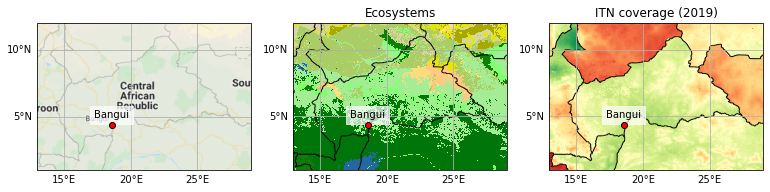

In [31]:
fig_sites(
    extent=(13, 29, 1, 12),
    sample_query='country == "Central African Republic"',
    bgzoom=5,
    gridlines=5,
)

## Cameroon

Mosquitoes from Cameroon were collected by three separate studies, sampling a number of different locations. Here's an overview of all Cameroon sites, then further details for each sample set are below.

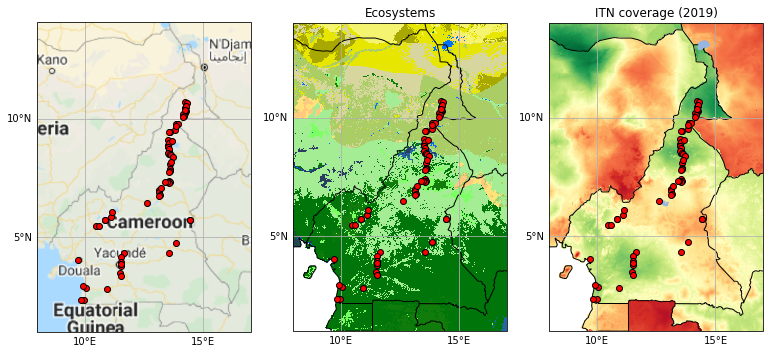

In [32]:
fig_sites(
    extent=(8, 17, 1, 14),
    sample_query='country == "Cameroon"',
    label_sites=False,
    bgzoom=5,
    gridlines=5,
);

### AG1000G-CM-C

Mosquitoes in this sample set were collected at 11 sites spread across Cameroon. Further details are given in [Kamdem et al. (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5400387/).

n_samples
sample_set   location     longitude latitude year taxon                
AG1000G-CM-C Afan-Essokye 9.983     2.367    2013 gambiae             1
             Campo        9.817     2.367    2013 coluzzii            2
             Douala       9.721     4.055    2013 coluzzii            2
             Lagdo        13.656    9.049    2013 arabiensis          2
                                                  coluzzii            1
             Manchoutvi   11.110    5.880    2013 gambiae             2
             Manda        10.868    5.726    2013 gambiae            11
             Mfelap       10.868    5.726    2013 gambiae             1
             Mgbandji     11.141    6.097    2013 gambiae             1
             Nkolondom    11.516    3.972    2013 coluzzii            5
                                                  gambiae             5
             Tibati       12.629    6.469    2013 coluzzii            2
                                                  gambiae             2
             Yaounde      11.506    3.880    2013 coluzzii            7

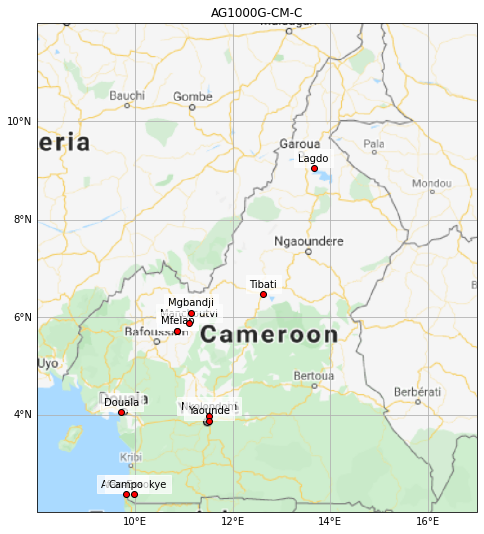

In [33]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-C"',
    gridlines=2,
    label_sites=True,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-C", **kwargs)

### AG1000G-CM-B

Mosquitoes in this sample set were collected in 2005 from 64 locations covering a 1,500 km north-to-south transect crossing all eco-geographical areas of Cameroon. The original study and collection sites are described in [Simard et al. (2009)](https://bmcecol.biomedcentral.com/articles/10.1186/1472-6785-9-17). 

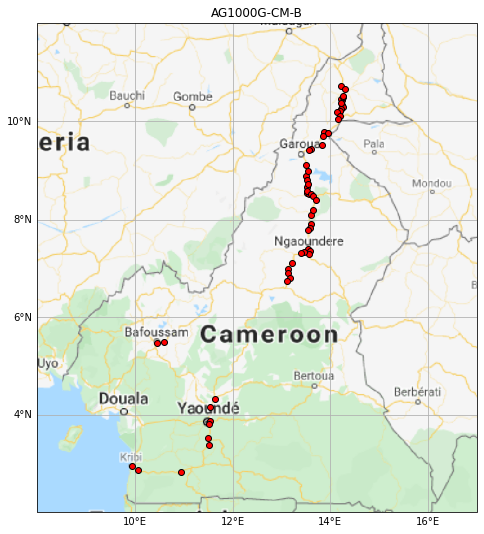

In [34]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-B"',
    gridlines=2,
    label_sites=False,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-B", **kwargs);

### AG1000G-CM-A

*An. gambiae* mosquitoes were collected from three villages comprising a transect from forest to savanna. Further details of the collections are in [Lobo et al. (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2988034/). 

n_samples
sample_set   location      longitude latitude year taxon             
AG1000G-CM-A Daiguene      13.844    4.777    2009 gambiae         96
             Gado Badzere  14.442    5.747    2009 gambiae         73
             Mayos         13.558    4.341    2009 gambiae        110
             Zembe Borongo 14.442    5.747    2009 gambiae         24

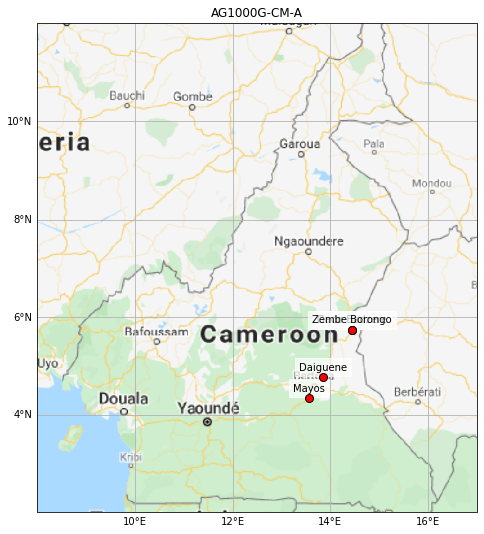

In [35]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8, 17, 2, 12),
    sample_query='country == "Cameroon" and sample_set == "AG1000G-CM-A"',
    gridlines=2,
    label_sites=True,
    plot_kws=dict(markerfacecolor='red', markersize=8)
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', bgzoom=6, ax=ax, title="AG1000G-CM-A", **kwargs)

## Gabon

*An. gambiae* mosquitoes were collected from the capital city, Libreville. Further information about malaria entomology and epidemiology in Libreville is available in [Pinto et al. (2006)](https://pubmed.ncbi.nlm.nih.gov/16608487/) and [Mourou et al. (2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3310827/).

n_samples
sample_set   location   longitude latitude year taxon             
AG1000G-GA-A Libreville 9.455     0.384    2000 gambiae         69

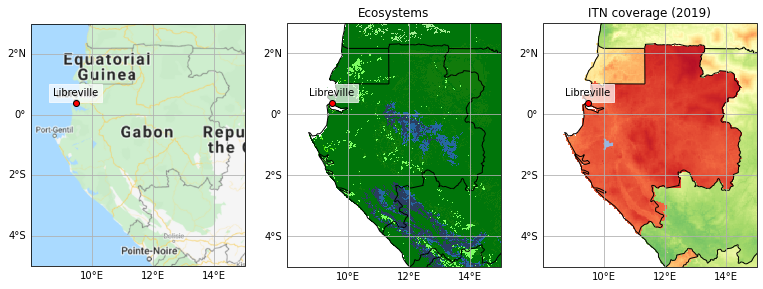

In [36]:
fig_sites(
    extent=(8, 15, -5, 3),
    sample_query='country == "Gabon"',
    bgzoom=6,
    gridlines=2,
)

## Angola

*An. coluzzii* mosquitoes were collected from peri-urban areas in Luanda province, in the west of Angola. See [Cuamba et al. (2006)](https://pubmed.ncbi.nlm.nih.gov/16420701/) and [Calzetta et al. (2008)](https://pubmed.ncbi.nlm.nih.gov/18187801/) for more information about malaria vectors in Angola.

n_samples
sample_set location longitude latitude year taxon              
AG1000G-AO Luanda   13.302    -8.884   2009 coluzzii         81

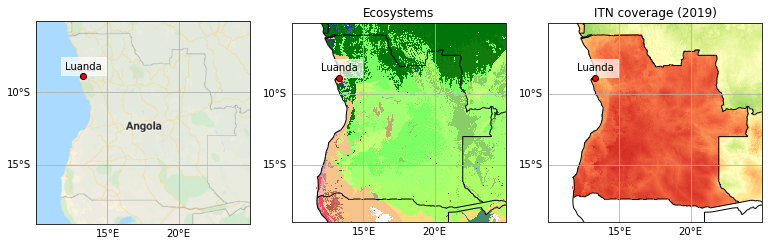

In [37]:
fig_sites(
    extent=(10, 25, -19, -5),
    sample_query='country == "Angola"',
    bgzoom=5,
    gridlines=5,
)

## Ghana

Mosquitoes were collected from four sites in southern Ghana during 2012. See [Essandoh et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/24206629/) for more information about these collections.

n_samples
sample_set location    longitude latitude year taxon              
AG1000G-GH Koforidua   -0.261    6.094    2012 coluzzii          1
                                               gambiae          23
           Madina      -0.219    5.668    2012 coluzzii         14
                                               gambiae          13
           Takoradi    -1.774    4.912    2012 coluzzii         24
           Twifo Praso -1.549    5.609    2012 coluzzii         25

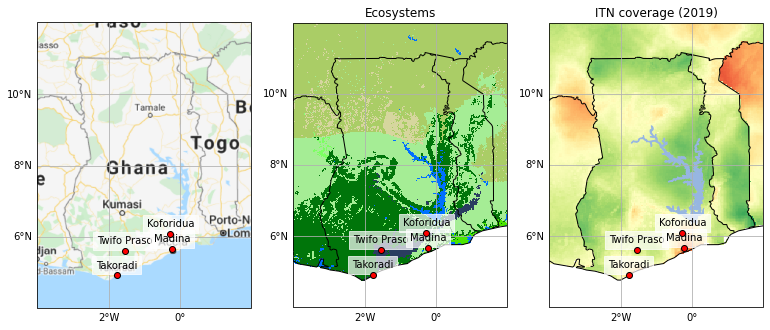

In [38]:
fig_sites(
    extent=(-4, 2, 4, 12),
    sample_query='country == "Ghana"',
    bgzoom=6,
    gridlines=2,
)

## Côte d'Ivoire

*An. coluzzii* mosquitoes were collected in Tiassale in southern Côte d'Ivoire. Further information about these specimens is available in [Grau-Bové et al. (2021)](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1009253). 

n_samples
sample_set location longitude latitude year taxon              
AG1000G-CI Tiassale -4.823    5.898    2012 coluzzii         80

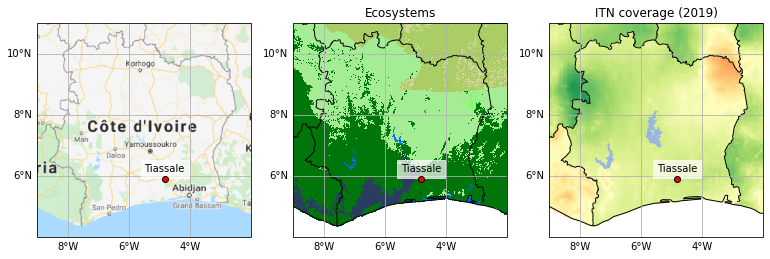

In [39]:
fig_sites(
    extent=(-9, -2, 4, 11),
    sample_query='country == "Cote d\'Ivoire"',
    bgzoom=6,
    gridlines=2,
)

## Burkina Faso

Mosquitoes were collected at four sites by two separate studies. Further details about the different collections is below.

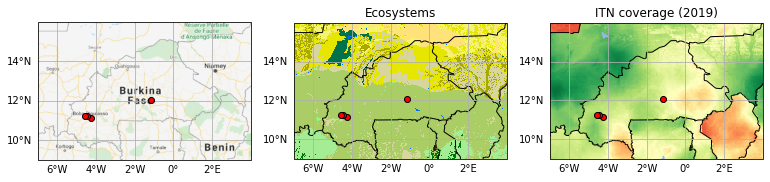

In [40]:
fig_sites(
    extent=(-7, 4, 9, 16),
    sample_query='country == "Burkina Faso"',
    bgzoom=6,
    label_sites=False,
    gridlines=2,
);

### AG1000G-BF-A, AG1000G-BF-B

Mosquitoes in these two sample sets were collected at three sites near to Bobo-Dioulasso, with sampling in both 2012 and 2014. These collections were performed as part of the [Target Malaria project](https://targetmalaria.org/).

n_samples
sample_set   location       longitude latitude year taxon                                   
AG1000G-BF-A Bana           -4.472    11.233   2012 coluzzii                              42
                                                    gambiae                               22
                                                    intermediate_gambiae_coluzzii          1
             Pala           -4.235    11.150   2012 coluzzii                              11
                                                    gambiae                               48
             Souroukoudinga -4.535    11.235   2012 coluzzii                              29
                                                    gambiae                               28
AG1000G-BF-B Bana           -4.472    11.233   2014 arabiensis                             1
                                                    coluzzii                              47
                                                    gambiae                               15
             Pala           -4.235    11.150   2014 arabiensis                             2
                                                    gambiae                               16
             Souroukoudinga -4.535    11.235   2014 coluzzii                               6
                                                    gambiae                               15

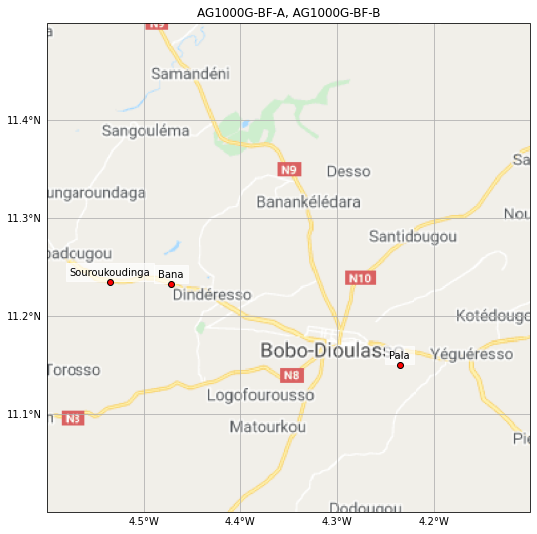

In [41]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-4.6, -4.1, 11, 11.5),
    gridlines=.1,
    sample_query='sample_set in ["AG1000G-BF-A", "AG1000G-BF-B"]',
    label_sites=True,
    bgzoom=10,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-BF-A, AG1000G-BF-B", **kwargs)

### AG1000G-BF-C

Mosquitoes in this sample set were collected from Monomtega in central Burkina Faso in 2004.

n_samples
sample_set   location   longitude latitude year taxon             
AG1000G-BF-C Monomtenga -1.17     12.06    2004 gambiae         13

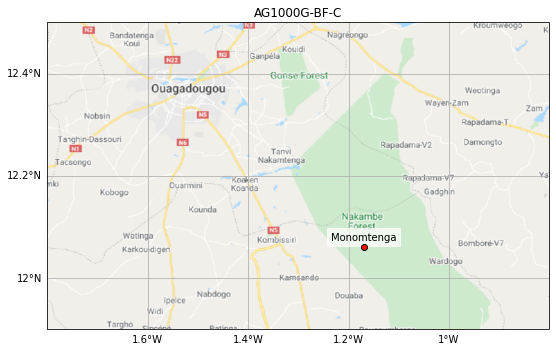

In [42]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-1.8, -0.8, 11.9, 12.5),
    gridlines=.2,
    sample_query='sample_set == "AG1000G-BF-C"',
    label_sites=True,
    bgzoom=10,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-BF-C", **kwargs)

## Mali

Mosquitoes from Mali were collected from several locations in the south west of the country in the context of three separate studies, described further below.

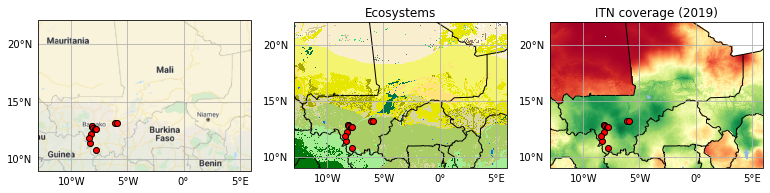

In [43]:
fig_sites(
    extent=(-13, 6, 9, 22),
    sample_query='country == "Mali"',
    bgzoom=5,
    gridlines=5,
    label_sites=False,
);

### AG1000G-GN-B (Mali)

Malian mosquitoes in this sample set were collected at two sites to the south of Bamako, further details are given in [Coulibaly et al. (2016)](https://malariajournal.biomedcentral.com/articles/10.1186/s12936-016-1242-5).

n_samples
sample_set   location       longitude latitude year taxon                                   
AG1000G-GN-B Takan          -8.33     11.47    2012 coluzzii                              26
                                                    gambiae                                5
             Toumani Oulena -7.81     10.83    2012 coluzzii                               2
                                                    gambiae                               60
                                                    intermediate_gambiae_coluzzii          1

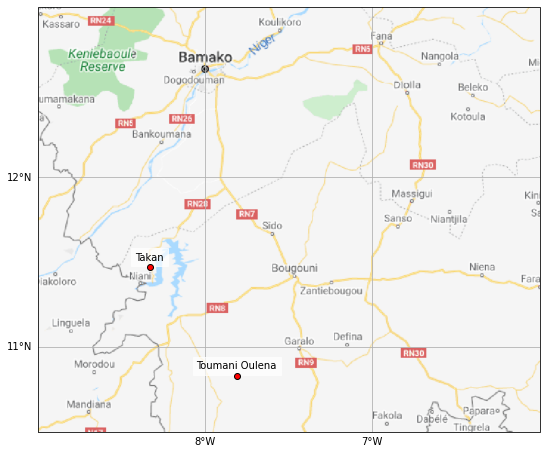

In [44]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-9, -6, 10.5, 13),
    gridlines=1,
    sample_query='country == "Mali" and sample_set == "AG1000G-GN-B"',
    label_sites=True,
    bgzoom=8,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, **kwargs)

### AG1000G-ML-A

Mosquitoes in this sample set were collected at three sites in close proximity, located to the north of Bamako. These collections were performed as part of the [Target Malaria project](https://targetmalaria.org/).

n_samples
sample_set   location       longitude latitude year taxon              
AG1000G-ML-A Kababougou     -8.15     12.89    2014 coluzzii         12
                                                    gambiae          28
             Ouassorola     -8.16     12.90    2014 coluzzii          9
                                                    gambiae           4
             Tieneguebougou -8.08     12.81    2014 coluzzii          6
                                                    gambiae           1

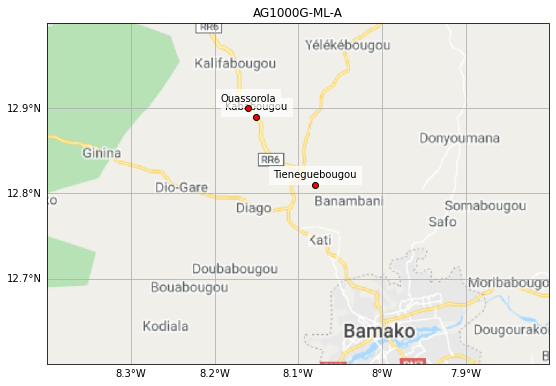

In [45]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-8.4, -7.8, 12.6, 13.0),
    gridlines=.1,
    sample_query='sample_set == "AG1000G-ML-A"',
    label_sites=True,
    bgzoom=10,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-ML-A", **kwargs)

### AG1000G-ML-B

Mosquitoes in this sample set were collected from seven villages in southern Mali, further details are given in [Coulibaly et al. (2007)](https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-6-133).

n_samples
sample_set   location     longitude latitude year taxon                
AG1000G-ML-B Bancoumana   -8.20     12.20    2004 gambiae             9
             Douna        -5.90     13.21    2004 arabiensis          1
                                                  coluzzii           19
             Fanzana      -6.13     13.20    2004 arabiensis          1
                                                  coluzzii            6
                                                  gambiae             1
             Kela         -8.45     11.88    2004 gambiae            23
             Moribobougou -7.87     12.69    2004 coluzzii            7
             N'Gabakoro   -7.84     12.68    2004 coluzzii            4

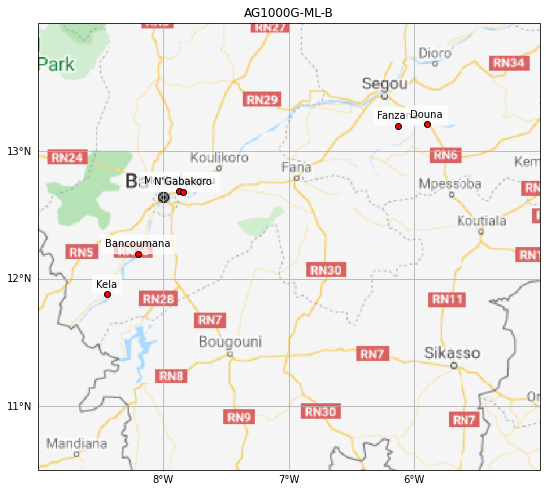

In [46]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-9, -5, 10.5, 14),
    gridlines=1,
    sample_query='sample_set == "AG1000G-ML-B"',
    label_sites=True,
    bgzoom=7,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-ML-B", **kwargs)

## Guinea

Mosquitoes were collected from two sites in south eastern Guinea, further details are given in [Coulibaly et al. (2016)](https://malariajournal.biomedcentral.com/articles/10.1186/s12936-016-1242-5).

n_samples
sample_set   location longitude latitude year taxon                                   
AG1000G-GN-A Koraboh  -10.03    9.28     2012 gambiae                               22
                                              intermediate_gambiae_coluzzii          1
             Koundara -9.53     8.48     2012 coluzzii                               3
                                              gambiae                               18
                                              gcx2                                   1
AG1000G-GN-B Koraboh  -10.03    9.28     2012 gambiae                               38
                                              intermediate_gambiae_coluzzii          1
             Koundara -9.53     8.48     2012 coluzzii                               7
                                              gambiae                               45

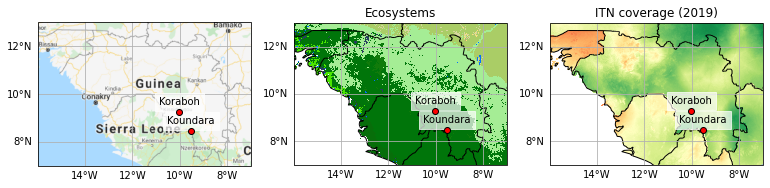

In [47]:
fig_sites(
    extent=(-16, -7, 7, 13),
    sample_query='country == "Guinea"',
    bgzoom=6,
    gridlines=2,
    label_sites=True,
)

## Guinea-Bissau

There are three collection sites in Guinea-Bissau, two coastal and one inland. Further details are available in [Vicente et al. (2017)](https://www.nature.com/articles/srep46451). At the coastal sites there are a significant fraction of mosquitoes with apparent intermediate *An. gambiae*/*An. coluzzii* species genotypes, which we're investigating further.

n_samples
sample_set location longitude latitude year taxon             
AG1000G-GW Antula   -15.582   11.891   2010 gcx1            60
           Leibala  -14.222   12.272   2010 gambiae          8
           Safim    -15.649   11.957   2010 gcx1            33

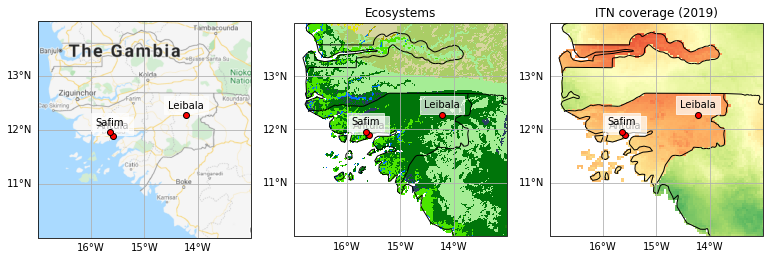

In [48]:
fig_sites(
    extent=(-17, -13, 10, 14),
    sample_query='country == "Guinea-Bissau"',
    bgzoom=7,
    gridlines=1,
    label_sites=True,
)

## The Gambia

Mosquitoes from The Gambia were contributed from various collection sites via three separate studies, described further below. At almost all of these sites there are mosquitoes with apparent intermediate *An. gambiae*/*An. coluzzii* species genotypes, similar to coastal Guinea-Bissau.

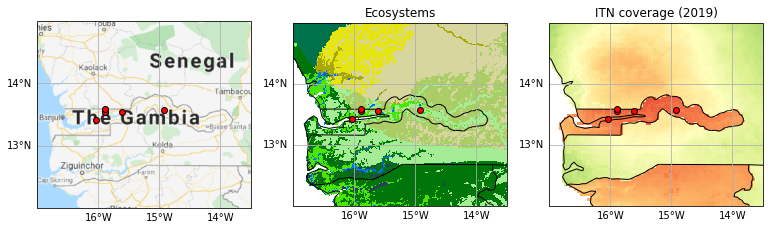

In [49]:
fig_sites(
    extent=(-17, -13.5, 12, 15),
    sample_query='country == "Gambia, The"',
    bgzoom=7,
    gridlines=1,
    label_sites=False,
);

### AG1000G-GM-A

Mosquitoes in this sample set were collected at Njabakunda, further details are given in [Nwakanma et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/23335339/).

n_samples
sample_set   location   longitude latitude year taxon           
AG1000G-GM-A Njabakunda -15.9     13.55    2011 gcx1          68
                                                gcx2           6

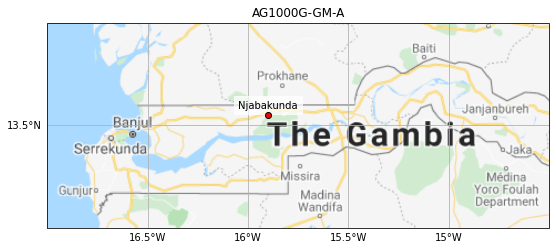

In [50]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-17, -14.5, 13, 14),
    gridlines=.5,
    sample_query='sample_set == "AG1000G-GM-A"',
    label_sites=True,
    bgzoom=8,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-GM-A", **kwargs)

### AG1000G-GM-B

Mosquitoes in this sample set were collected from three sites along the Gambia River, further details are given in [Caputo et al. (2008)](https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-7-182).

n_samples
sample_set   location        longitude latitude year taxon              
AG1000G-GM-B Kalataba        -15.617   13.550   2012 gcx2              1
             Sare Samba Sowe -15.900   13.583   2012 gcx1              9
                                                     gcx2              2
             Tankular        -16.033   13.417   2012 coluzzii          2
                                                     gcx2             17

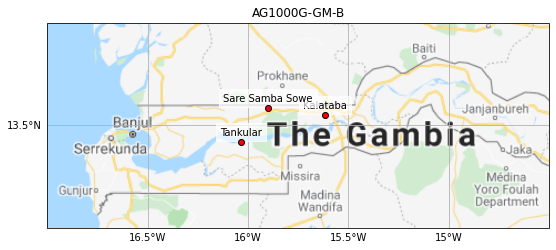

In [51]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-17, -14.5, 13, 14),
    gridlines=.5,
    sample_query='sample_set == "AG1000G-GM-B"',
    label_sites=True,
    bgzoom=8,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-GM-B", **kwargs)

### AG1000G-GM-C

Mosquitoes in this sample set were collected at Wali Kunda in the rural central river region of The Gambia. Further details are given in [Fabrigar (2015)](https://ora.ox.ac.uk/objects/uuid:1e65b4bf-48fb-4921-a20b-8d8f7d0bdd12).

n_samples
sample_set   location   longitude latitude year taxon             
AG1000G-GM-C Wali Kunda -14.917   13.567   2012 gambiae          2
                                                gcx2           172

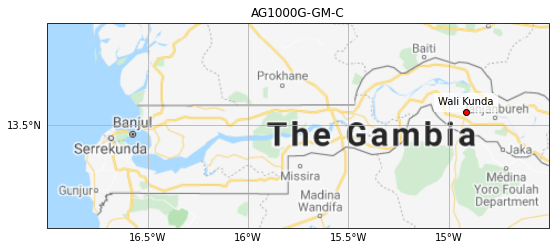

In [52]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(-17, -14.5, 13, 14),
    gridlines=.5,
    sample_query='sample_set == "AG1000G-GM-C"',
    label_sites=True,
    bgzoom=8,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-GM-C", **kwargs)

## Mayotte Island

Returning to East Africa, Mayotte Island is one of the two oceanic islands represented. Seven collection sites were sampled.

n_samples
sample_set location                 longitude latitude year taxon             
AG1000G-FR Bouyouni                 45.142    -12.738  2011 gambiae          1
           Combani                  45.143    -12.779  2011 gambiae          6
           Karihani Lake            45.122    -12.797  2011 gambiae          3
           Mont Benara              45.155    -12.857  2011 gambiae          2
           Mtsamboro Forest Reserve 45.081    -12.703  2011 gambiae          1
           Mtsanga Charifou         45.156    -12.991  2011 gambiae          7
           Sada                     45.104    -12.852  2011 gambiae          3

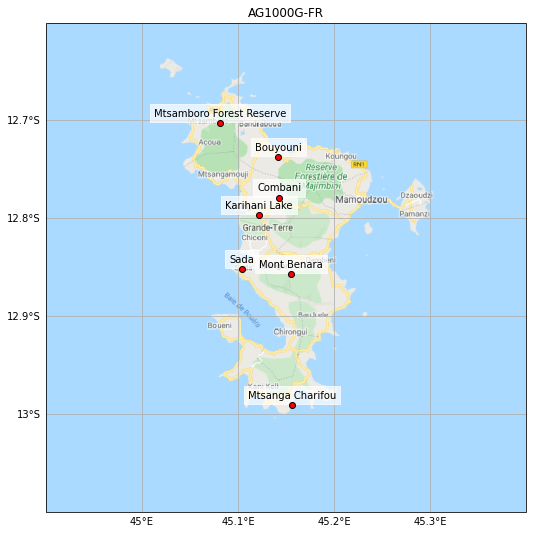

In [53]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(44.9, 45.4, -13.1, -12.6),
    gridlines=.1,
    sample_query='country == "Mayotte"',
    label_sites=True,
    bgzoom=11,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-FR", **kwargs)

## Bioko Island

*An. gambiae* mosquitoes were collected from a location in the north part of the island. Further information on malaria vector biology in Bioko is available in [Overgaard et al. (2012)](https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-11-56) and [Vontas et al. (2018)](https://www.pnas.org/content/115/18/4619.short).

n_samples
sample_set location longitude latitude year taxon             
AG1000G-GQ Bioko    8.7       3.7      2002 gambiae         10

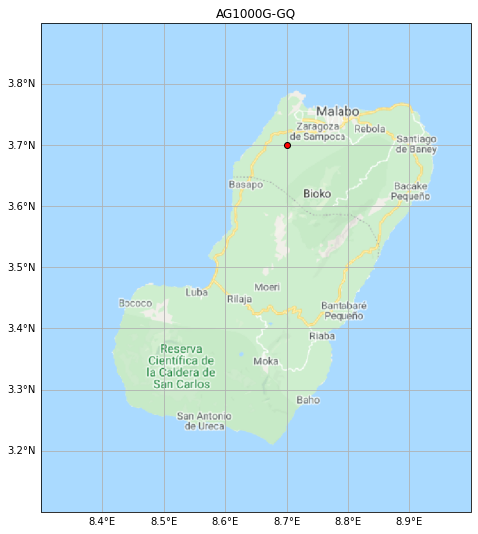

In [54]:
fig = plt.figure(figsize=(9, 9))
kwargs = dict(
    extent=(8.3, 9.0, 3.1, 3.9),
    gridlines=.1,
    sample_query='country == "Equatorial Guinea"',
    label_sites=False,
    bgzoom=10,
)
ax = fig.add_subplot(1, 1, 1, projection=crs_mercator)
plot_sites(background='google', ax=ax, title="AG1000G-GQ", **kwargs)

## Further reading

Hopefully this notebook is a useful resource for exploring the locations sampled in Ag1000G phase 3. Further information on the people and research studies that contributed mosquito specimens and the collection sites is available in the [Ag1000G phase 3 contributing studies](https://storage.googleapis.com/vo_agam_release/v3/ag1000g-phase3-contributing-studies.pdf) document.